# ML Solution in Trading

- Carolina Martínez Escalante
- Antonio Lomelí Ureña
- Enrique Tonatiuh Pérez Cortés Barba

## Problem Description

Machine learning offers a powerful alternative to traditional trading strategies by enabling models to learn patterns from historical market data and make data-driven decisions. 

Among these models, logistic regression is particularly valuable for predicting binary outcomes—such as whether an asset’s return will be positive or negative. 

Its interpretability, efficiency, and ability to handle high-dimensional data make it a common starting point in financial applications, especially when paired with technical indicators or engineered features to forecast short-term price movements.

## Objective

In this notebook we'll develope two ML pipelines using logistic regression. In the first one (Part 1) we'll create a generic logistic regression with standardized data, in the second case (Part 2) the data will be transformed using PCA, then optimize parameters using grid search and cross validation.

By comparing this two alternatives the we will reflect in the potential and business implications of ML algorithms for trading decission (open/close positions).

## Methodology

The data set of prices, indicators and "signal" (the target) is provided as `SPY_dataset_project.csv`. Furthermore, 6 indicators from technical analysis will be included.

- Overlay Indicators:
    - 6 day Simple Moving Average
    - 14 day Simple Moving Average
    - 5 day Rolling Volatility
    - Volume Change
- Oscilators:
    - Relative Strenght Index (14 day avg)
    - MACD 

Training and test data are divided in a 70/30 ratio, using sklearn module selection.

Then data is divided between numerical and categorical features. Numerical features are transformed using `Standard Scaler`, while categorical features are encoded using `OneHotEncoder`. The Principal Component Analysis (PCA) is made for case 2, using `PCA` library, all of the above from sklearn.

Classes are balanced using `SMOTE` library from imblearn, and the pipelines are created using this library as well. 

Finally, the linear regession model, cross validation, and grid search for parameter optimization are implemented using sklearn modules.

## ML Solutions


### Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from Utils import rsi_indicator, macd_indicator
from Utils import metrics

### Data Import and Indicators

In [2]:
data = pd.read_csv('SPY_dataset_project.csv', keep_default_na=False, na_values=[''," "])

# Creation of returns and indicators columns
data['r'] = np.log(data['Close'] / data['Close'].shift(1))
# Overlays
data["SMA_6"] = data["Close"].rolling(6).mean()
data["SMA_14"] = data["Close"].rolling(14).mean()
data["Vol_5"] = data["Close"].rolling(5).std()
data["Volume_change"] = data["Volume"].pct_change()
# Oscilators
data["RSI"] = rsi_indicator(data['Close'])
data["MACD"] = macd_indicator(data['Close'])

# Drop rows with NaN values
data.dropna(inplace=True)

data.head()

,Date,Close,Volume,return,signal,market_sentiment,recession_expectation,growing_sector,investor_type,news_impact,policy_uncertainty,r,SMA_6,SMA_14,Vol_5,Volume_change,RSI,MACD
13,2023-07-11,432.262634,64463800,0.006368,1,negative,low,health,retail,negative,medium,0.006348,431.039800,428.275253,1.940888,0.032354,63.361751,0.121508
14,2023-07-12,435.740570,91924500,0.008046,1,neutral,low,manufacturing,retail,neutral,medium,0.008014,431.402903,429.048440,2.953608,0.425986,67.476313,0.318742
15,2023-07-13,439.198975,72425200,0.007937,1,positive,high,finance,retail,neutral,low,0.007906,432.449880,429.959098,4.452668,-0.212123,69.379239,0.579032
16,2023-07-14,438.925415,69761800,-0.000623,0,neutral,high,manufacturing,retail,positive,high,-0.000623,434.016251,431.080499,4.211525,-0.036774,76.215334,0.682262
17,2023-07-17,440.449463,52680200,0.003472,1,neutral,low,health,retail,positive,low,0.003466,436.017375,432.434274,3.315603,-0.244856,81.865919,0.773490


### Train Test Split

In [3]:
# Divide the data into features and target variable
X = data[['Close', 'Volume', 'market_sentiment',
        'recession_expectation', 'growing_sector', 'investor_type',
        'news_impact', 'policy_uncertainty', 
        'r', 'SMA_6', 'SMA_14', 'Vol_5', 'Volume_change', 'RSI', 'MACD']]
y = data['signal']
# Make the split for the training and test sets of the model
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, stratify=y, random_state=42)

### Pre-processing

In [4]:
# Divide features by data type
categorical_features = ['market_sentiment',
                        'recession_expectation', 'growing_sector', 'investor_type',
                        'news_impact', 'policy_uncertainty']
numerical_features = ['Close', 'Volume',  
                      'r', 'SMA_6', 'SMA_14', 'Vol_5', 
                      'Volume_change', 'RSI', 'MACD']
# Create the pre processing pipeline
preprocessor = ColumnTransformer(
    transformers = [
        ('cat',OneHotEncoder(drop='first'),categorical_features),
        ('num',StandardScaler(),numerical_features)
    ]
)

### Part 1 (Generic LR)

In [5]:
# Build the pipeline with the preprocessor, SMOTE for oversampling, and the lr classifier
pipeline = ImbPipeline([
    ('preprocessor',preprocessor),
    ('sampler',SMOTE(random_state=42)),
    ('classifier',LogisticRegression()) # We won't change any parameters for the classifier
])

# Train the pipeline on the training data
pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['market_sentiment',
                                                   'recession_expectation',
                                                   'growing_sector',
                                                   'investor_type',
                                                   'news_impact',
                                                   'policy_uncertainty']),
                                                 ('num', StandardScaler(),
                                                  ['Close', 'Volume', 'r',
                                                   'SMA_6', 'SMA_14', 'Vol_5',
                                                   'Volume_change', 'RSI',
                                                   'MACD'])])),
                ('sampler', SMOTE(random_state=42)),
                ('classifier', LogisticRegression())])

Accuracy Train 0.9706744868035191
Train Set Results: 
               precision    recall  f1-score   support

           0       0.95      0.98      0.97       144
           1       0.98      0.96      0.97       197

    accuracy                           0.97       341
   macro avg       0.97      0.97      0.97       341
weighted avg       0.97      0.97      0.97       341



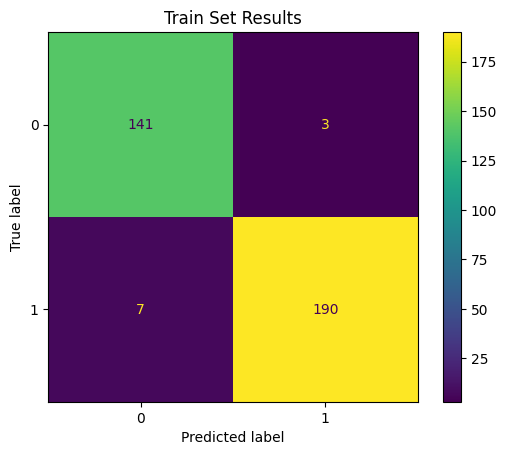

Accuracy Test 0.9727891156462585
Test Set Results: 
               precision    recall  f1-score   support

           0       0.95      0.98      0.97        62
           1       0.99      0.96      0.98        85

    accuracy                           0.97       147
   macro avg       0.97      0.97      0.97       147
weighted avg       0.97      0.97      0.97       147



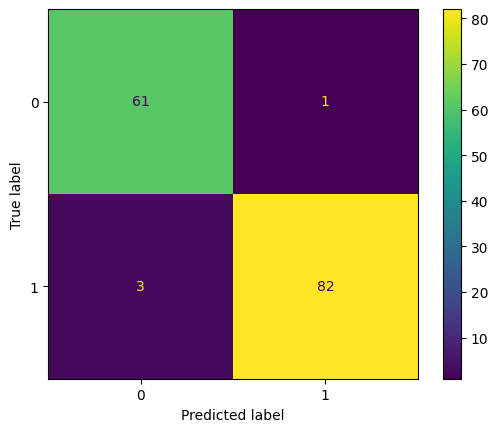

In [ ]:
# Train Set
y_pred_train = pipeline.predict(X_train)
accuracy_train, metrics_report_train, cm_train = metrics(y_train, y_pred_train, pipeline, title = "Train Set Results")

# Test Set
y_pred_test = pipeline.predict(X_test)
accuracy_test, metrics_report_test, cm_test = metrics(y_test, y_pred_test, pipeline, title = "Test Set Results")

In [9]:
dir(ConfusionMatrixDisplay.plot.__setattr__)

['__call__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__name__',
 '__ne__',
 '__new__',
 '__objclass__',
 '__qualname__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__self__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__text_signature__']